In [ ]:
# ==========================================
# 1. IMPORTS & KAGGLE DOWNLOAD
# ==========================================
import os

os.environ['KAGGLE_USERNAME'] = "dnyaneshwarimodhave"
os.environ['KAGGLE_KEY'] = "5bdec8136a12228ebc48a046b31f3013"

!kaggle datasets download -d asdasdasasdas/garbage-classification
!unzip -n garbage-classification.zip -d dataset

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.utils import load_img, img_to_array

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard

In [ ]:
# ==========================================
# 2. DATA PREPROCESSING
# ==========================================
train_dir = "dataset/Garbage classification/Garbage classification"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="training"
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="validation"
)

num_classes = train_gen.num_classes
labels = list(train_gen.class_indices.keys())

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [ ]:
# ==========================================
# 3. BUILD MODEL FUNCTIONS
# ==========================================

# --- ORIGINAL CNN ---
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        layers.MaxPooling2D(2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# --- EfficientNetB0 ---
def build_efficientnet():
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# --- MobileNetV2 ---
def build_mobilenet():
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base.input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

 TRAINING: CNN



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.2567 - loss: 1.7852 - val_accuracy: 0.3579 - val_loss: 1.5465
Epoch 2/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.4101 - loss: 1.4055 - val_accuracy: 0.4115 - val_loss: 1.4791
Epoch 3/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.4799 - loss: 1.3210 - val_accuracy: 0.3897 - val_loss: 1.4260
Epoch 4/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.5380 - loss: 1.1813 - val_accuracy: 0.4632 - val_loss: 1.3353
Epoch 5/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.5481 - loss: 1.1623 - val_accuracy: 0.4115 - val_loss: 1.3444
Epoch 6/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.5701 - loss: 1.1587 - val_accuracy: 0.4573 - val_loss: 1.3137
Epoch 7/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.5895 - loss: 1.0652 - val_accuracy: 0.4553 - val_loss: 1.3574
Epoch 8/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.5884 - loss: 1.0811 - val_accuracy: 0.4891 - val_loss:

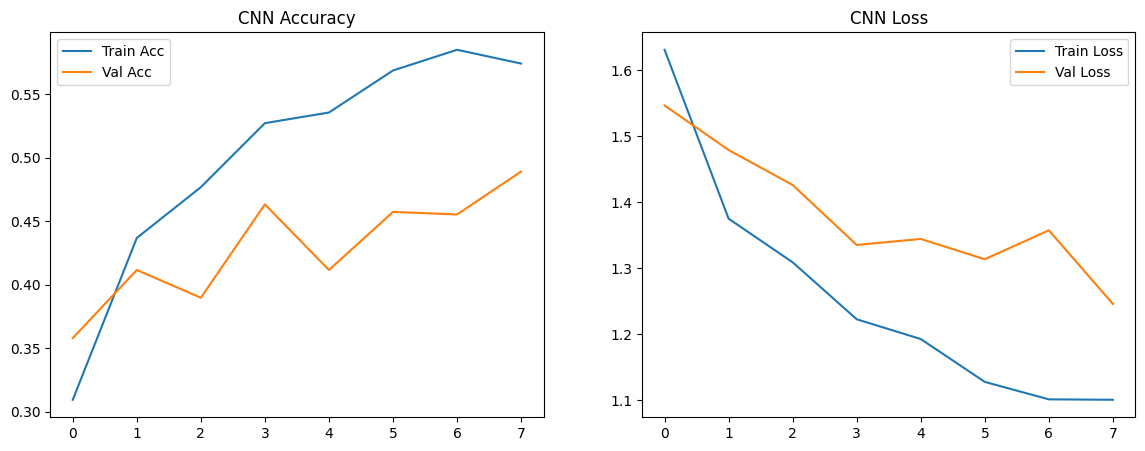


 TRAINING: EfficientNetB0

Epoch 1/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.2108 - loss: 1.7841 - val_accuracy: 0.1988 - val_loss: 1.7338
Epoch 2/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.2069 - loss: 1.7507 - val_accuracy: 0.2346 - val_loss: 1.7279
Epoch 3/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.2219 - loss: 1.7354 - val_accuracy: 0.2346 - val_loss: 1.7293
Epoch 4/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.2427 - loss: 1.7348 - val_accuracy: 0.2346 - val_loss: 1.7234
Epoch 5/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.2156 - loss: 1.7400 - val_accuracy: 0.2346 - val_loss: 1.7240
Epoch 6/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.2400 - loss: 1.7240 - val_accuracy: 0.2346 - val_loss: 1.7255
Epoch 7/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.2414 - loss: 1.7323 - val_accuracy: 0.2346 - val_loss: 1.7228
Epoch 8/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.2471 - loss: 1.7213 - val_

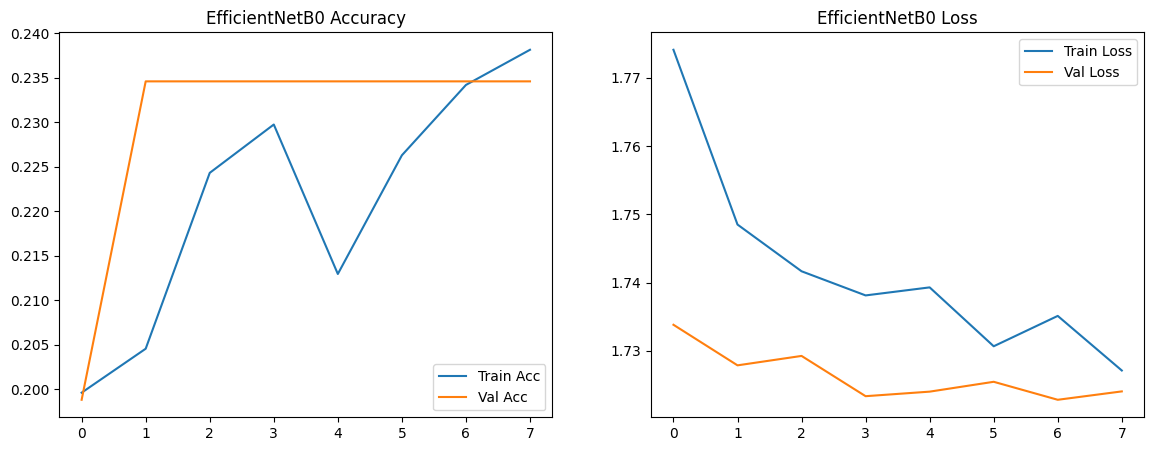


 TRAINING: MobileNetV2

Epoch 1/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4914 - loss: 1.3935 - val_accuracy: 0.6600 - val_loss: 0.8268
Epoch 2/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7539 - loss: 0.6396 - val_accuracy: 0.7157 - val_loss: 0.7034
Epoch 3/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8261 - loss: 0.4760 - val_accuracy: 0.7197 - val_loss: 0.7075
Epoch 4/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8522 - loss: 0.4173 - val_accuracy: 0.7256 - val_loss: 0.7187
Epoch 5/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8658 - loss: 0.3639 - val_accuracy: 0.7515 - val_loss: 0.6624
Epoch 6/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8803 - loss: 0.3234 - val_accuracy: 0.7435 - val_loss: 0.6982
Epoch 7/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9070 - loss: 0.2706 - val_accuracy: 0.7535 - val_loss: 0.7049
Epoch 8/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9196 - loss: 0.2454 - val_accuracy: 0

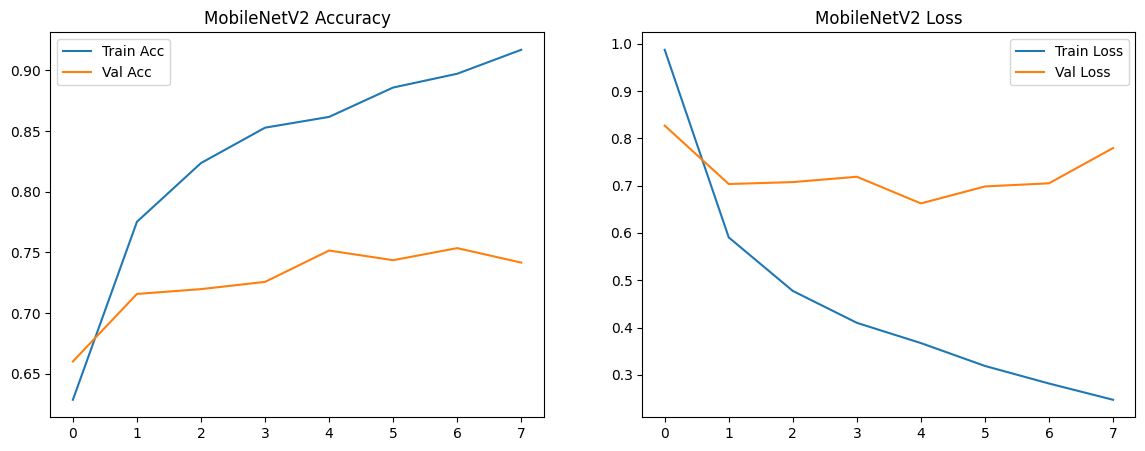

In [6]:
# ==========================================
# 4. TRAIN MULTIPLE MODELS
# ==========================================
models_to_train = {
    "CNN": build_cnn(),
    "EfficientNetB0": build_efficientnet(),
    "MobileNetV2": build_mobilenet()
}

EPOCHS = 8
results = {}

for model_name, model in models_to_train.items():
    print("\n==============================")
    print(f" TRAINING: {model_name}")
    print("==============================\n")

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        verbose=1
    )

    # Save results
    val_loss, val_acc = model.evaluate(val_gen)
    results[model_name] = {
        "model": model,
        "val_acc": val_acc,
        "history": history
    }

    print(f"\n🔥 {model_name} Validation Accuracy: {val_acc*100:.2f}%\n")

    # ========== ACCURACY & LOSS PLOT FOR EACH MODEL ==========
    plt.figure(figsize=(14,5))

    # ACCURACY
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    # LOSS
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.show()

In [7]:
# ==========================================
# 5. SHOW FINAL ACCURACY OF ALL MODELS
# ==========================================
print("\n==============================")
print(" FINAL VALIDATION ACCURACY")
print("==============================\n")

for model_name, data in results.items():
    print(f"{model_name}: {data['val_acc']*100:.2f} %")


 FINAL VALIDATION ACCURACY

CNN: 48.71 %
EfficientNetB0: 23.46 %
MobileNetV2: 76.94 %



🏆 BEST MODEL SELECTED: MobileNetV2
Model saved as best_model.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 871ms/step


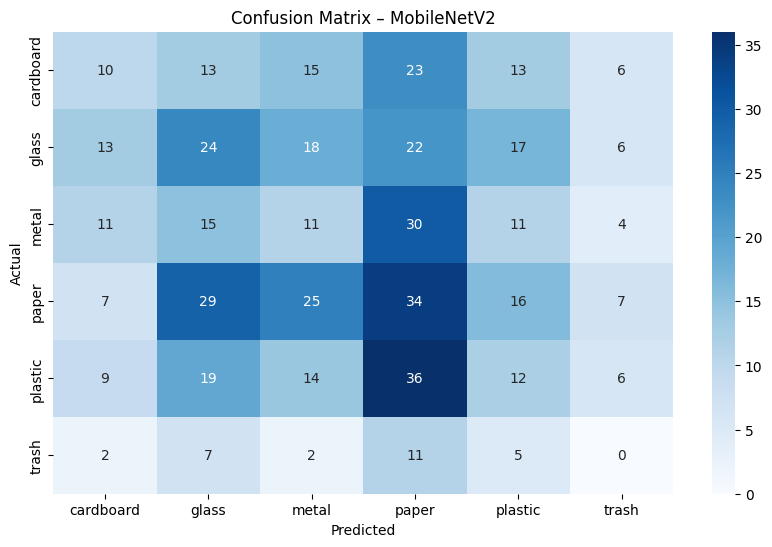


Classification Report:

              precision    recall  f1-score   support

   cardboard       0.19      0.12      0.15        80
       glass       0.22      0.24      0.23       100
       metal       0.13      0.13      0.13        82
       paper       0.22      0.29      0.25       118
     plastic       0.16      0.12      0.14        96
       trash       0.00      0.00      0.00        27

    accuracy                           0.18       503
   macro avg       0.15      0.15      0.15       503
weighted avg       0.18      0.18      0.18       503



In [17]:
# ==========================================
# 6. CONFUSION MATRIX FOR BEST MODEL
# ==========================================
best_model_name = max(results, key=lambda x: results[x]["val_acc"])
best_model = results[best_model_name]["model"]

print(f"\n🏆 BEST MODEL SELECTED: {best_model_name}")

# >>>>>>> ADD THIS PART <<<<<<<<
best_model.save("best_model.h5")
print("Model saved as best_model.h5")
# >>>>>>>  END  <<<<<<<<

val_gen.reset()
y_true = val_gen.classes
y_pred = np.argmax(best_model.predict(val_gen), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title(f"Confusion Matrix – {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


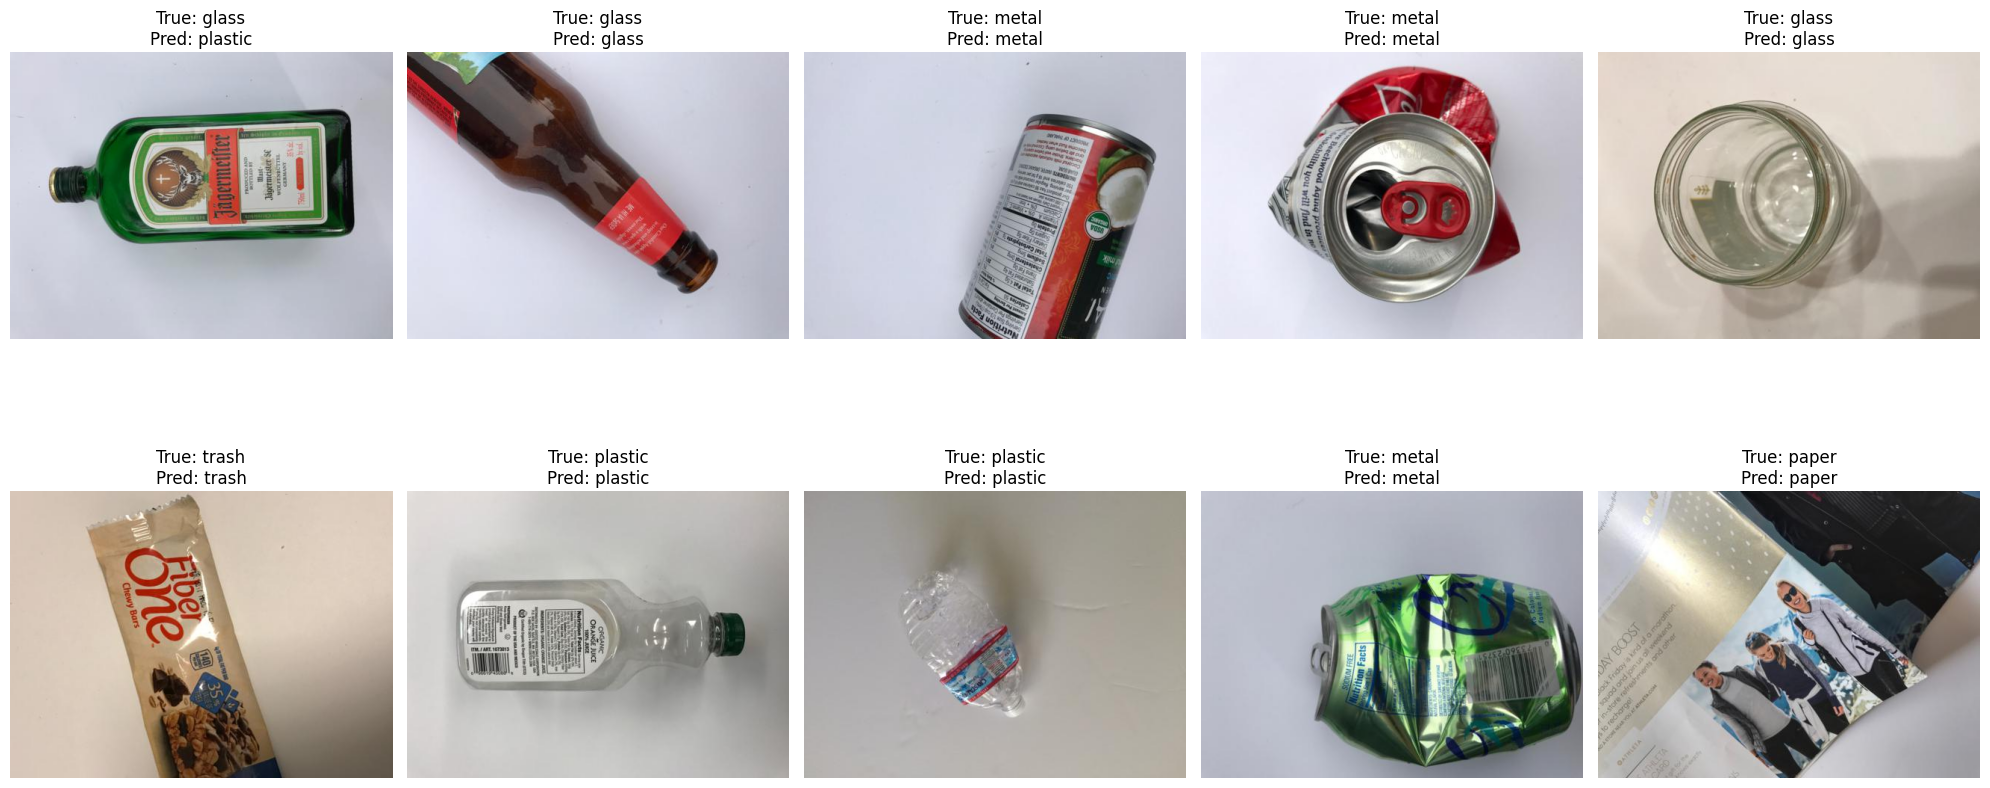

In [10]:
# ==========================================
# 8. PREDICTION OF 10 RANDOM IMAGES
# ==========================================
sample_paths = random.sample(all_files, 10)

plt.figure(figsize=(20,10))

for i, path in enumerate(sample_paths):
    true_l = os.path.basename(os.path.dirname(path))

    img = load_img(path, target_size=IMG_SIZE)
    x = img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)

    pred = best_model.predict(x)
    pred_label = labels[np.argmax(pred)]

    plt.subplot(2,5,i+1)
    plt.imshow(load_img(path))
    plt.title(f"True: {true_l}\nPred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()